## Tacotron 2 inference code 
Edit the variables **checkpoint_path** and **text** to match yours and run the entire code to generate plots of mel outputs, alignments and audio synthesis from the generated mel-spectrogram using Griffin-Lim.

#### Import libraries and setup matplotlib

In [1]:
import matplotlib
import matplotlib.pylab as plt

import IPython.display as ipd

import sys
sys.path.append('waveglow/')
import numpy as np
import torch

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


In [2]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')

#### Setup hparams

In [3]:
hparams = create_hparams()
hparams.sampling_rate = 22050
hparams.is_training = False

#### Load model from checkpoint

In [ ]:
# Run the following commands if you want to convert 
# nvidia/tacotron2 pretrained model to haiku model.
#
! gdown --id 1c5ZTuT7J08wLUoVZ2KkUs_VdZuJ86ZqA     # download the pretrained model tacotron2_statedict.pt
! python torch2haiku.py --torch-checkpoint=tacotron2_statedict.pt --hk-path=ck.pt   # convert to ck.pt

In [4]:
from hk_trainer import Trainer
trainer = Trainer(config=hparams)
trainer.load_checkpoint("ck.pt")     ## ck.pt is a haiku model
trainer.to_device()

Remember to call trainer.to_device()


In [5]:
# checkpoint_path = "tacotron2_statedict.pt"
# model = load_model(hparams)
# model.load_state_dict(torch.load(checkpoint_path, map_location=torch.device("cpu"))['state_dict'])
# _ = model.eval()

#### Prepare text input

In [6]:
text = "Waveglow is really awesome!"
sequence = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).long()

#### Decode text input and plot results

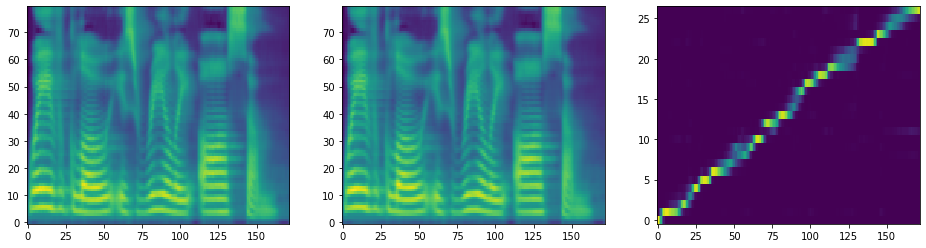

In [7]:
mel_outputs, mel_outputs_postnet, _, alignments = trainer.inference(sequence.numpy())

%matplotlib inline
plot_data((mel_outputs[0],
           mel_outputs_postnet[0],
           alignments[0].T))
plt.show()

In [ ]:
# mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
# %matplotlib inline
# plot_data((mel_outputs.float().data.cpu().numpy()[0],
#            mel_outputs_postnet.float().data.cpu().numpy()[0],
#            alignments.float().data.cpu().numpy()[0].T))
# plt.show()

#### Load WaveGlow for mel2audio synthesis and denoiser

In [ ]:
waveglow_path = 'waveglow_256channels.pt'
waveglow = torch.load(waveglow_path)['model']
waveglow.cuda().eval()
for k in waveglow.convinv:
    k.float()

from denoiser import Denoiser
denoiser = Denoiser(waveglow)

#### Synthesize audio from spectrogram using WaveGlow

In [ ]:
with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

#### (Optional) Remove WaveGlow bias

In [ ]:
audio_denoised = denoiser(audio, strength=0.01)[:, 0]
ipd.Audio(audio_denoised.cpu().numpy(), rate=hparams.sampling_rate) 